In [3]:
#Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from tensorflow import keras

import pickle
import warnings
warnings.filterwarnings("ignore")


In [4]:
#Load dataset

from src.utils import load_dataset

data = load_dataset("../data/Telco-Customer-Churn.csv")
data.head()



,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


EDA

In [6]:
data.describe()


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2281.916928
std,0.368612,24.559481,30.090047,2265.270398
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


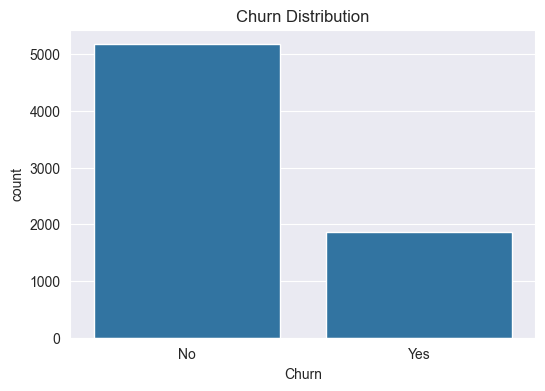

In [7]:
plt.figure(figsize=(6,4))
sns.countplot(x="Churn", data=data)
plt.title("Churn Distribution")
plt.show()


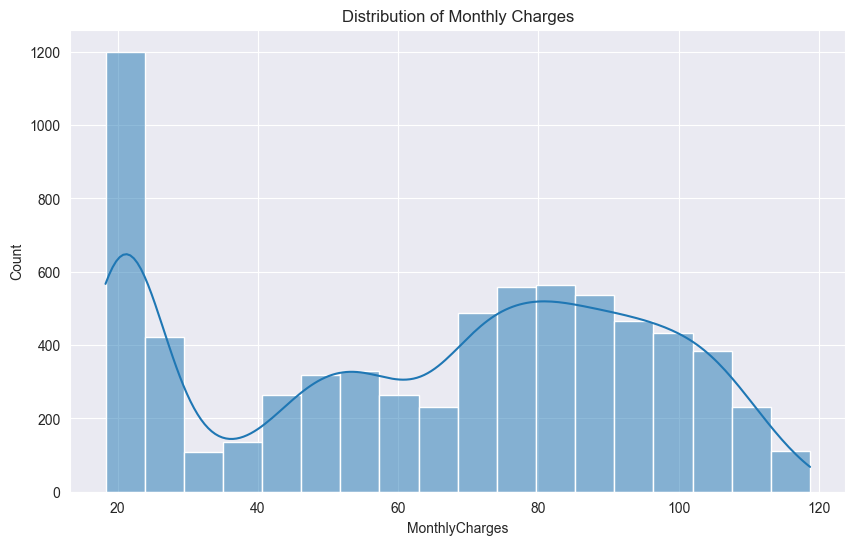

In [8]:
plt.figure(figsize=(10,6))
sns.histplot(data["MonthlyCharges"], kde=True)
plt.title("Distribution of Monthly Charges")
plt.show()


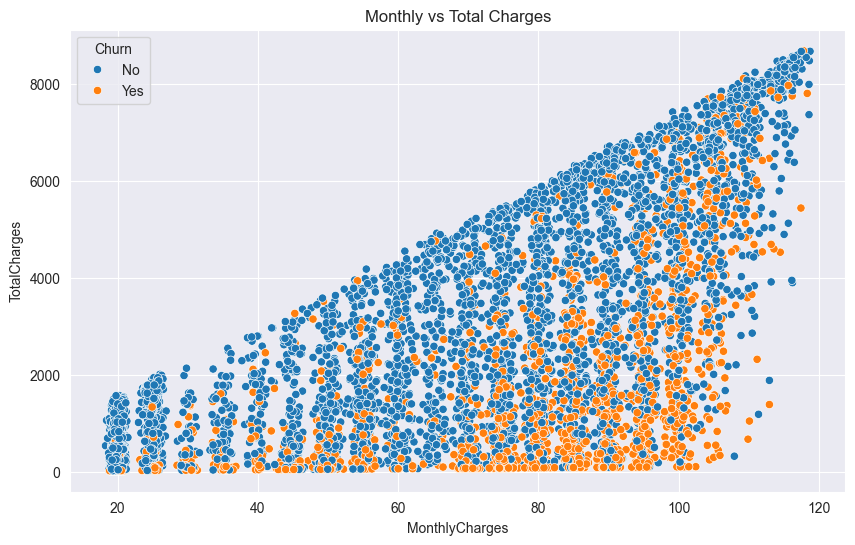

In [9]:
plt.figure(figsize=(10,6))
sns.scatterplot(x="MonthlyCharges", y="TotalCharges", hue="Churn", data=data)
plt.title("Monthly vs Total Charges")
plt.show()


Preprocessing

In [10]:
# Encode target
data["Churn"] = data["Churn"].map({"Yes": 1, "No": 0})

# Identify categorical columns
cat_cols = data.select_dtypes(include="object").columns.tolist()

# Label encode all categorical columns
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    encoders[col] = le

# Scale numeric columns
num_cols = ["tenure", "MonthlyCharges", "TotalCharges"]
scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])

# Save encoders and scaler
pickle.dump(encoders, open("../results/label_encoders.pkl", "wb"))
pickle.dump(scaler, open("../results/scaler.pkl", "wb"))


Train/Test Split

In [11]:
X = data.drop("Churn", axis=1)
y = data["Churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Decision Tree Model


In [12]:
dt = DecisionTreeClassifier(max_depth=6, random_state=42)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

# Save model
pickle.dump(dt, open("../results/dt_model.pkl", "wb"))


Decision Tree Accuracy: 0.7984386089425124
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1036
           1       0.63      0.59      0.61       373

    accuracy                           0.80      1409
   macro avg       0.74      0.73      0.74      1409
weighted avg       0.79      0.80      0.80      1409



Neural Network Model


In [13]:
nn = keras.Sequential([
    keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = nn.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=32)


Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6379 - loss: 12.2289 - val_accuracy: 0.3824 - val_loss: 1.3240
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6647 - loss: 1.4359 - val_accuracy: 0.3141 - val_loss: 4.4136
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6925 - loss: 1.1341 - val_accuracy: 0.7551 - val_loss: 1.1385
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7173 - loss: 0.8340 - val_accuracy: 0.7081 - val_loss: 0.5848
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7302 - loss: 0.7837 - val_accuracy: 0.7924 - val_loss: 0.4329
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7029 - loss: 1.3390 - val_accuracy: 0.7657 - val_loss: 0.7811
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7118 - loss: 1.0256 - val_accuracy: 0.7657 - val_loss: 0.9143
Epoch 8/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7324 - loss: 0.7627 - val_accuracy: 0

Evaluate Neural Network

In [14]:
nn_loss, nn_acc = nn.evaluate(X_test, y_test)
print("Neural Network Accuracy:", nn_acc)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7835 - loss: 0.5226
Neural Network Accuracy: 0.7835344076156616


Save Neural Network

In [15]:
nn.save("../results/nn_model.keras")


Training Curves

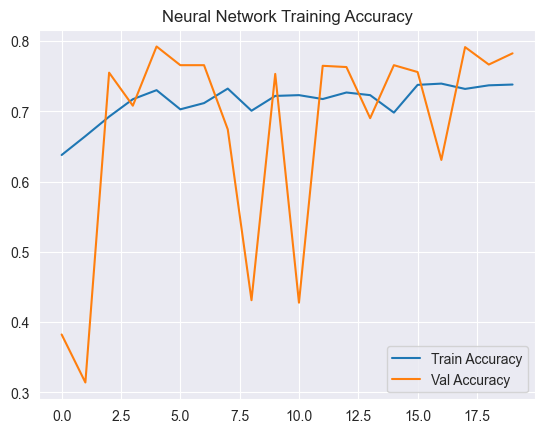

In [16]:
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.legend()
plt.title("Neural Network Training Accuracy")
plt.show()
